# Document Classification Slides - Kiva

Predict the rating of a review, given it's text.

- Stephen W. Thomas
- Used for MMAI 891 and MMA/GMMA 865.
- The Simple and Easy Version

In [1]:
import pandas as pd

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import datetime
print(datetime.datetime.now())

2020-12-08 14:43:02.769356


# Read Data

In [3]:
kiva_df = pd.read_csv("../data/kiva_cleaned.csv")
kiva_df = kiva_df.dropna()
kiva_df = kiva_df.reset_index(drop=True)
kiva_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6802 entries, 0 to 6801
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   loan_id      6802 non-null   int64 
 1   status       6802 non-null   object
 2   sector       6802 non-null   object
 3   country      6802 non-null   object
 4   gender       6802 non-null   object
 5   loan_amount  6802 non-null   int64 
 6   nonpayment   6802 non-null   object
 7   en_clean     6802 non-null   object
dtypes: int64(2), object(6)
memory usage: 425.2+ KB


# EDA

In [4]:
kiva_df.head()

,loan_id,status,sector,country,gender,loan_amount,nonpayment,en_clean
0,0,defaulted,Agriculture,Kenya,M,500,lender,"Robert, 40, is married and has 6 children. In ..."
1,1,defaulted,Food,Kenya,F,500,lender,"Petronilla, 30, was deserted by her husband an..."
2,2,defaulted,Food,Kenya,M,500,lender,"Tom Mung'ahu, 45, is married and has 6 childre..."
3,3,defaulted,Services,Kenya,F,500,lender,"Benedina, 42, is married and has 4 girls. In a..."
4,4,defaulted,Construction,Kenya,M,500,lender,"Vincent Ondego 40, is married and has 8 childr..."


In [5]:
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

In [6]:
doc = nlp(kiva_df.iloc[5000].en_clean)
displacy.render(doc, style="ent")

# Preprocessing

In [7]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import unidecode

stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

lemmer = WordNetLemmatizer()

def preprocess(x):
    x = x.lower()
    
    x = re.sub(r'[^\w\s]', '', x)
    
    x = unidecode.unidecode(x)
    
    #x = re.sub(r'\d+', '', x)
    
    x = [lemmer.lemmatize(w) for w in x.split() if w not in stop_words]

    return ' '.join(x)

kiva_df['en_clean_pre'] = kiva_df['en_clean'].apply(preprocess)

In [8]:
kiva_df.head()

,loan_id,status,sector,country,gender,loan_amount,nonpayment,en_clean,en_clean_pre
0,0,defaulted,Agriculture,Kenya,M,500,lender,"Robert, 40, is married and has 6 children. In ...",robert 40 married 6 child addition family 8 ta...
1,1,defaulted,Food,Kenya,F,500,lender,"Petronilla, 30, was deserted by her husband an...",petronilla 30 deserted husband responsible upb...
2,2,defaulted,Food,Kenya,M,500,lender,"Tom Mung'ahu, 45, is married and has 6 childre...",tom mungahu 45 married 6 child child attending...
3,3,defaulted,Services,Kenya,F,500,lender,"Benedina, 42, is married and has 4 girls. In a...",benedina 42 married 4 girl addition family 6 a...
4,4,defaulted,Construction,Kenya,M,500,lender,"Vincent Ondego 40, is married and has 8 childr...",vincent ondego 40 married 8 child beside famil...


In [9]:
kiva_df.iloc[0, :].en_clean

'Robert, 40, is married and has 6 children. In addition to his family of 8, he takes care of his mother and 5 brothers. Robert started by planting vegetables and selling at the local market. He then diversified with a tea nursery which is more profitable. Given a loan of $500, Robert will be able to improve his activities by buying fertilizers, pesticides, a pump and seedlings. The pump will remove the uncertainties of the weather. The current capital in his venture is Ksh 10500 or $150, which does not allow Robert to maximize his potential. Robert completed high school and has never got employment. He got apprentice training from a tea extension officer. He is a go getter, and his main hobby is teaching music.'

In [10]:
kiva_df.iloc[0, :].en_clean_pre

'robert 40 married 6 child addition family 8 take care mother 5 brother robert started planting vegetable selling local market diversified tea nursery profitable given loan 500 robert able improve activity buying fertilizer pesticide pump seedling pump remove uncertainty weather current capital venture ksh 10500 150 allow robert maximize potential robert completed high school never got employment got apprentice training tea extension officer go getter main hobby teaching music'

# Feature Extraction

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df = 0.5, min_df=0.05, max_features = 1000, ngram_range=[1,3])
dtm = vectorizer.fit_transform(kiva_df['en_clean_pre'])

In [12]:
dtm.shape

(6802, 272)

In [13]:
bow_df = pd.DataFrame(dtm.toarray(), 
                      columns=vectorizer.get_feature_names(), 
                      index=kiva_df.index)

features = pd.concat([kiva_df, bow_df], axis=1)
features.shape
features.head()

(6802, 281)

,loan_id,status,sector,country,gender,loan_amount,nonpayment,en_clean,en_clean_pre,10,...,woman,woman group,work,working,would,would like,year ago,year old,year old married,young
0,0,defaulted,Agriculture,Kenya,M,500,lender,"Robert, 40, is married and has 6 children. In ...",robert 40 married 6 child addition family 8 ta...,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,1,defaulted,Food,Kenya,F,500,lender,"Petronilla, 30, was deserted by her husband an...",petronilla 30 deserted husband responsible upb...,0.000000,...,0.094161,0.14103,0.000000,0.0,0.114314,0.0,0.0,0.0,0.0,0.0
2,2,defaulted,Food,Kenya,M,500,lender,"Tom Mung'ahu, 45, is married and has 6 childre...",tom mungahu 45 married 6 child child attending...,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,3,defaulted,Services,Kenya,F,500,lender,"Benedina, 42, is married and has 4 girls. In a...",benedina 42 married 4 girl addition family 6 a...,0.000000,...,0.000000,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,4,defaulted,Construction,Kenya,M,500,lender,"Vincent Ondego 40, is married and has 8 childr...",vincent ondego 40 married 8 child beside famil...,0.202618,...,0.000000,0.00000,0.127459,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [14]:
import textstat
  
features['len'] = features['en_clean'].apply(lambda x: len(x))
features['syllable_count'] = features['en_clean'].apply(
    lambda x: textstat.syllable_count(x))
features['flesch_reading_ease'] = features['en_clean'].apply(
    lambda x: textstat.flesch_reading_ease(x))

features.head()

,loan_id,status,sector,country,gender,loan_amount,nonpayment,en_clean,en_clean_pre,10,...,working,would,would like,year ago,year old,year old married,young,len,syllable_count,flesch_reading_ease
0,0,defaulted,Agriculture,Kenya,M,500,lender,"Robert, 40, is married and has 6 children. In ...",robert 40 married 6 child addition family 8 ta...,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,719,187,67.15
1,1,defaulted,Food,Kenya,F,500,lender,"Petronilla, 30, was deserted by her husband an...",petronilla 30 deserted husband responsible upb...,0.000000,...,0.0,0.114314,0.0,0.0,0.0,0.0,0.0,1096,275,73.47
2,2,defaulted,Food,Kenya,M,500,lender,"Tom Mung'ahu, 45, is married and has 6 childre...",tom mungahu 45 married 6 child child attending...,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,688,175,74.49
3,3,defaulted,Services,Kenya,F,500,lender,"Benedina, 42, is married and has 4 girls. In a...",benedina 42 married 4 girl addition family 6 a...,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,591,150,65.12
4,4,defaulted,Construction,Kenya,M,500,lender,"Vincent Ondego 40, is married and has 8 childr...",vincent ondego 40 married 8 child beside famil...,0.202618,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,659,172,76.01


In [15]:
features = features.drop(
    columns=['loan_id', 'sector', 'country', 'gender', 
             'loan_amount', 'nonpayment', 'en_clean', 'en_clean_pre'],
    axis=1)

# Build Model

In [16]:
from sklearn.model_selection import train_test_split

y = features['status']
X = features.drop(['status'], axis=1)

feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [17]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)

clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

# Assess Performance

In [18]:
y_pred_dt = clf.predict(X_test)

In [19]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_dt)

array([[605, 239],
       [224, 633]], dtype=int64)

In [20]:
from sklearn.metrics import classification_report

class_names = [str(x) for x in clf.classes_]

print(classification_report(y_test, y_pred_dt, target_names=class_names))

              precision    recall  f1-score   support

   defaulted       0.73      0.72      0.72       844
        paid       0.73      0.74      0.73       857

    accuracy                           0.73      1701
   macro avg       0.73      0.73      0.73      1701
weighted avg       0.73      0.73      0.73      1701



# Interpret Model

In [21]:
from sklearn.tree import export_text

print(export_text(clf, feature_names = list(feature_names)))

|--- repay loan <= 0.05
|   |--- requesting <= 0.02
|   |   |--- loan usd <= 0.09
|   |   |   |--- expand business <= 0.25
|   |   |   |   |--- cement <= 0.18
|   |   |   |   |   |--- active member <= 0.08
|   |   |   |   |   |   |--- dominican <= 0.05
|   |   |   |   |   |   |   |--- second <= 0.08
|   |   |   |   |   |   |   |   |--- belief <= 0.10
|   |   |   |   |   |   |   |   |   |--- goal <= 0.13
|   |   |   |   |   |   |   |   |   |   |--- operates <= 0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 52
|   |   |   |   |   |   |   |   |   |   |--- operates >  0.05
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 11
|   |   |   |   |   |   |   |   |   |--- goal >  0.13
|   |   |   |   |   |   |   |   |   |   |--- sale <= 0.12
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 12
|   |   |   |   |   |   |   |   |   |   |--- sale >  0.12
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch

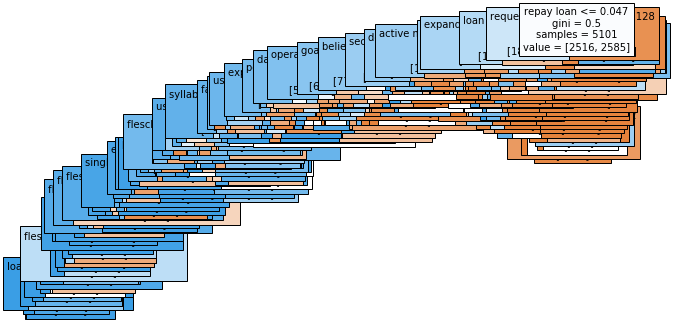

In [22]:
# Needs sklearn 0.21 or higher
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=[10,5]);
plot_tree(clf, filled=True, feature_names = feature_names, label='root', fontsize=10)
plt.show();

In [23]:
clf.feature_importances_

array([0.        , 0.00329706, 0.00171676, 0.00539459, 0.00315548,
       0.        , 0.02044565, 0.00267032, 0.00811393, 0.00062769,
       0.        , 0.00318022, 0.0007686 , 0.00765352, 0.00185733,
       0.00283835, 0.00147501, 0.00058846, 0.00158265, 0.        ,
       0.00146284, 0.00207993, 0.        , 0.0013575 , 0.00505355,
       0.01093028, 0.00263766, 0.00211052, 0.00350112, 0.00200471,
       0.00169909, 0.00521798, 0.        , 0.00555457, 0.00291678,
       0.02111493, 0.00183006, 0.00143842, 0.00114708, 0.        ,
       0.00417422, 0.00033431, 0.00339486, 0.        , 0.01396533,
       0.00431341, 0.        , 0.00207226, 0.00052307, 0.00405575,
       0.01322197, 0.00206834, 0.00659198, 0.0022844 , 0.0016997 ,
       0.        , 0.0021991 , 0.0025434 , 0.        , 0.01431945,
       0.00138353, 0.        , 0.00075361, 0.        , 0.00129663,
       0.        , 0.0034475 , 0.01014517, 0.        , 0.00420687,
       0.00142066, 0.01906067, 0.00058846, 0.00190627, 0.00775

In [24]:
imp = clf.tree_.compute_feature_importances(normalize=False)
ind = sorted(range(len(imp)), key=lambda i: imp[i])[-15:]

imp[ind]
feature_names[ind]

array([0.00660718, 0.00692543, 0.00697865, 0.00715561, 0.00772904,
       0.00817582, 0.00847379, 0.00907034, 0.00942248, 0.00952486,
       0.01021694, 0.0105514 , 0.01197912, 0.01845457, 0.0524518 ])

Index(['customer', 'second', 'community', 'dominican', 'family', 'school',
       'flesch_reading_ease', 'invest', 'syllable_count', 'expand business',
       'active member', 'cement', 'loan usd', 'requesting', 'repay loan'],
      dtype='object')